# Preamble
**Name:** Deborah Djon</br>
**Student Number:** 22261972</br>
**Module Code:** CA694</br>
**Module Name:** Practicum</br>
**Supervisor:** Dr. Geoff Hamilton</br>

## **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

# CNN With Collected Data

## Imports

In [1]:
import sys
sys.path.append("../..")

import tensorflow as tf

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from modelling_utilities import data_processing
from modelling_utilities.constants import *
from modelling_utilities.visualisation import *
import json
from sklearn.preprocessing import minmax_scale

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, MeanAbsoluteError, FalseNegatives
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2023-07-26 02:17:13.626393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 02:17:14.509342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-07-26 02:17:16.934216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:17:16.969343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:17:16.969599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
vid_map_fp = META_DATA_FOLDER+"all_ids_title_pseudonym_ids.json"
with open (vid_map_fp, "r") as f:
    vname_2_vid_map = json.load(f)
vname_2_vid_map
vid_2_vname_map = {v:k for k,v in vname_2_vid_map.items()}


In [5]:
fp_feature = "adf_sparse" # mpfp , mpfp sparse, sdf, sdf sparse, bpts
#fn = DATA_FOLDER + "Processed_Data/data-ms-aggregates/data-0470-ms-aggregate.parquet"
fn = OPEN_WORLD_PROCESSED_DATA_FOLDER+"Train/Pre_Processed_Bin_Aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"
data = data_processing.read_parquet_to_pandas(fn)
vid_2_vname_map["unknown"] = "unknown"
data["class"] = data["class"].map(vid_2_vname_map)
data["video_id"] = data["video_id"].map(vid_2_vname_map)
data = data[data["class"]!="unknown"]
display(data)

fn = OPEN_WORLD_PROCESSED_DATA_FOLDER+"Test/Pre_Processed_Bin_Aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"
data_test = data_processing.read_parquet_to_pandas(fn)
data_test["class"] = data_test["class"].map(vid_2_vname_map)
data_test["video_id"] = data_test["video_id"].map(vid_2_vname_map)
data_test = data_test[data_test["class"]!="unknown"]
display(data_test)

,ts,bpts,video_id,cw,class,ts_i,bpi,ts_f,bpi_sparse,df,df_sparse,mpdf,mpdf_sparse,sdf,sdf_sparse,ndf,ndf_sparse,adf,adf_sparse
1715,"[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[5863.0, 5863.0, 5949.0, 72940.0, 22823.0, 268...",Video 35,1,Video 35,"[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[11.639011711145091, 14.901190246565104, 9.907...","[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[11.639011711145091, 14.901190246565104, 9.907...","[0.2802796849406269, -0.33510154759368016, 0.5...","[0.2802796849406269, -0.33510154759368016, 0.5...","[0.21892066884871714, -0.33510154759368016, 0....","[0.21892066884871714, -0.33510154759368016, 0....","[3.262178535420013, -4.993411912611819, 5.2906...","[3.262178535420013, -4.993411912611819, 5.2906...","[0.12291460858579929, -0.20127446638523175, 0....","[0.12291460858579929, -0.20127446638523175, 0....","[3.262178535420013, 4.993411912611819, 5.29064...","[3.262178535420013, 4.993411912611819, 5.29064..."
93,"[2023-06-06T17:19:57.460000, 2023-06-06T17:20:...","[0.0, 5860.0, 5860.0, 5685.0, 26825.0, 5253.0,...",Video 2,1,Video 2,"[2023-06-06T17:20:08.270000, 2023-06-06T17:20:...","[9.764512800245539, 12.508459816101027, 9.9116...","[2023-06-06T17:20:08.270000, 2023-06-06T17:20:...","[9.764512800245539, 12.508459816101027, 9.9116...","[0.2810121786912388, -0.2076079176526794, 0.49...","[0.2810121786912388, -0.2076079176526794, 0.49...","[0.2193672967093398, -0.2076079176526794, 0.33...","[0.2193672967093398, -0.2076079176526794, 0.33...","[2.743947015855488, -2.5968552954629516, 4.937...","[2.743947015855488, -2.5968552954629516, 4.937...","[0.12319626406048972, -0.11582729007639647, 0....","[0.12319626406048972, -0.11582729007639647, 0....","[2.743947015855488, 2.5968552954629516, 4.9372...","[2.743947015855488, 2.5968552954629516, 4.9372..."
1059,"[2023-06-21T20:50:40.520000, 2023-06-21T20:50:...","[0.0, 885.0, 73125.0, 5863.0, 5813.0, 51612.0,...",Video 22,1,Video 22,"[2023-06-21T20:50:51.040000, 2023-06-21T20:50:...","[11.358444730680988, 13.27337312967902, 14.850...","[2023-06-21T20:50:51.040000, 2023-06-21T20:50:...","[11.358444730680988, 0.0, 13.27337312967902, 0...","[0.16859072209292023, 0.11880274563135763, -0....","[0.16859072209292023, 0.0, 0.11880274563135763...","[0.14426840715539652, 0.1061873919198468, -0.3...","[0.14426840715539652, 0.0, 0.1061873919198468,...","[1.9149283989980326, 1.5769131715953542, -4.74...","[1.9149283989980326, 0.0, 1.5769131715953542, ...","[0.07774206556145932, 0.05607069647059428, -0....","[0.07774206556145932, 0.0, 0.05607069647059428...","[1.9149283989980326, 1.5769131715953542, 4.740...","[1.9149283989980326, 0.0, 1.5769131715953542, ..."
1783,"[2023-06-26T17:47:57.760000, 2023-06-26T17:47:...","[5861.0, 5861.0, 72836.0, 6164.0, 43303.0, 344...",Video 36,1,Video 36,"[2023-06-26T17:47:57.760000, 2023-06-26T17:47:...","[11.345192968419566, 10.809061059569078, 12.09...","[2023-06-26T17:47:57.760000, 2023-06-26T17:47:...","[11.345192968419566, 10.809061059569078, 12.09...","[-0.047256305850668395, 0.11884977071442263, -...","[-0.047256305850668395, 0.11884977071442263, -...","[-0.047256305850668395, 0.1062249587257216, -0...","[-0.047256305850668395, 0.1062249587257216, -0...","[-0.5361319088504874, 1.284654428567979, -2.19...","[-0.5361319088504874, 1.284654428567979, -2.19...","[-0.024199953118401712, 0.056091645739636126, ...","[-0.024199953118401712, 0.056091645739636126, ...","[0.5361319088504874, 1.284654428567979, 2.1970...","[0.5361319088504874, 1.284654428567979, 2.1970..."
78,"[2023-06-06T17:48:48.930000, 2023-06-06T17:48:...","[0.0, 5860.0, 5860.0, 73338.0, 6208.0, 5299.0,...",Video 2,1,Video 2,"[2023-06-06T17:48:59.590000, 2023-06-06T17:49:...","[11.421533598539797, 12.53715538486695, 9.9117...","[2023-06-06T17:48:59.590000, 2023-06-06T17:49:...","[11.421533598539797, 0.0, 12.53715538486695, 9...","[0.09767705682446884, -0.20941366657452043, 0....","[0.09767705682446884, 0.0, -0.2094136665745204...","[0.08898524

,ts,bpts,video_id,cw,class,ts_i,bpi,ts_f,bpi_sparse,df,df_sparse,mpdf,mpdf_sparse,sdf,sdf_sparse,ndf,ndf_sparse,adf,adf_sparse
530,"[2023-06-21T21:28:23.770000, 2023-06-21T21:28:...","[0.0, 5863.0, 5863.0, 72787.0, 5672.0, 35037.0...",Video 11,1,Video 11,"[2023-06-21T21:28:34.090000, 2023-06-21T21:28:...","[11.4096183951043, 12.234713550905097, 14.8894...","[2023-06-21T21:28:34.090000, 2023-06-21T21:28:...","[11.4096183951043, 0.0, 12.234713550905097, 14...","[0.072315753886636, 0.216980258407323, 0.02008...","[0.072315753886636, 0.0, 0.216980258407323, 0....","[0.06743886175739346, 0.17829398374242136, 0.0...","[0.06743886175739346, 0.0, 0.17829398374242136...","[0.8250951558007973, 2.6546913078149643, 0.298...","[0.8250951558007973, 0.0, 2.6546913078149643, ...","[0.03489610777267293, 0.09787198491483251, 0.0...","[0.03489610777267293, 0.0, 0.09787198491483251...","[0.8250951558007973, 2.6546913078149643, 0.298...","[0.8250951558007973, 0.0, 2.6546913078149643, ..."
1453,"[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[5861.0, 72869.0, 5861.0, 5648.0, 35055.0, 268...",Video 30,1,Video 30,"[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[11.410216985110202, 12.045939104025056, 11.18...","[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[11.410216985110202, 12.045939104025056, 11.18...","[0.05571516472863241, -0.07166013211685476, 0....","[0.05571516472863241, -0.07166013211685476, 0....","[0.052774807628110355, -0.07166013211685476, 0...","[0.052774807628110355, -0.07166013211685476, 0...","[0.6357221189148543, -0.8632135876660225, 3.66...","[0.6357221189148543, -0.8632135876660225, 3.66...","[0.027102570280444067, -0.03716156747592446, 0...","[0.027102570280444067, -0.03716156747592446, 0...","[0.6357221189148543, 0.8632135876660225, 3.664...","[0.6357221189148543, 0.8632135876660225, 3.664..."
2386,"[2023-06-12T15:10:35.700000, 2023-06-12T15:10:...","[5860.0, 5860.0, 76190.0, 72127.0, 26931.0, 51...",Video 48,1,Video 48,"[2023-06-12T15:10:35.700000, 2023-06-12T15:10:...","[9.369052063131004, 11.907107154057906, 13.258...","[2023-06-12T15:10:35.700000, 2023-06-12T15:10:...","[9.369052063131004, 0.0, 11.907107154057906, 1...","[0.2708977465195897, 0.11349372943116375, -0.0...","[0.2708977465195897, 0.0, 0.11349372943116375,...","[0.2131546359740233, 0.10192579125626763, -0.0...","[0.2131546359740233, 0.0, 0.10192579125626763,...","[2.5380550909269015, 1.3513819976505221, -0.68...","[2.5380550909269015, 0.0, 1.3513819976505221, ...","[0.11929103674296714, 0.05369958181125525, -0....","[0.11929103674296714, 0.0, 0.05369958181125525...","[2.5380550909269015, 1.3513819976505221, 0.687...","[2.5380550909269015, 0.0, 1.3513819976505221, ..."
69,"[2023-06-06T17:12:15.810000, 2023-06-06T17:12:...","[5588.0, 5860.0, 5860.0, 34616.0, 198455.0, 50...",Video 2,1,Video 2,"[2023-06-06T17:12:15.810000, 2023-06-06T17:12:...","[9.758924101344775, 12.576394051502756, 14.836...","[2023-06-06T17:12:15.810000, 2023-06-06T17:12:...","[9.758924101344775, 12.576394051502756, 0.0, 0...","[0.2887070255797702, 0.1797369780264181, -0.32...","[0.2887070255797702, 0.1797369780264181, 0.0, ...","[0.224028440793116, 0.15235343248043315, -0.32...","[0.224028440793116, 0.15235343248043315, 0.0, ...","[2.8174699501579816, 2.2604430612865265, -4.87...","[2.8174699501579816, 2.2604430612865265, 0.0, ...","[0.12614416015375998, 0.08245810381634024, -0....","[0.12614416015375998, 0.08245810381634024, 0.0...","[2.8174699501579816, 2.2604430612865265, 4.878...","[2.8174699501579816, 2.2604430612865265, 0.0, ..."
1740,"[2023-06-21T20:16:29.090000, 2023-06-21T20:16:...","[5863.0, 5863.0, 72940.0, 5503.0, 11324.0, 228...",Video 35,1,Video 35,"[2023-06-21T20:16:29.090000, 2023-06-21T20:16:...","[11.730581990051672, 14.916371316927416, 15.19...","[2023-06-21T20:16:29.090000, 2023-06-21T20:16:...","[11.730581990051672, 14.916371316927416, 0.0, ...","[0.27157981842482404, 0.01890906601405799, -0....","[0.27157981842482404, 0.01890906601405799, 0.0...","[0.21357

## Data Transfotmation

In [6]:
video_ids = list(data["class"].unique())
print("Number of classes", len(video_ids))
data["bpts_sparse"] = data[["ts","bpts"]].apply(lambda row: data_processing.stretch_measures_to_seconds(row["ts"], row["bpts"]), axis=1)
data[fp_feature] = data[fp_feature].apply(minmax_scale)

data_test["bpts_sparse"] = data_test[["ts","bpts"]].apply(lambda row: data_processing.stretch_measures_to_seconds(row["ts"], row["bpts"]), axis=1)
data_test[fp_feature] = data_test[fp_feature].apply(minmax_scale)


Number of classes 50


## Create Dataset

In [7]:
data = data[["class", fp_feature]]
display(data)
data_test = data_test[["class", fp_feature]]
display(data_test)


,class,adf_sparse
1715,Video 35,"[0.41522116883613264, 0.6355784357976584, 0.67..."
93,Video 2,"[0.5557657733643543, 0.525973454756495, 1.0, 0..."
1059,Video 22,"[0.40397010882520995, 0.0, 0.3326629788720036,..."
1783,Video 36,"[0.06991300749336114, 0.16752230786528205, 0.2..."
78,Video 2,"[0.22648430302806827, 0.0, 0.5329974733494138,..."
...,...,...
2320,Video 47,"[0.39918932019072917, 0.28621790639070227, 0.3..."
1089,Video 22,"[0.7395561209998047, 0.0, 0.33302627776050936,..."
753,Video 16,"[0.1335250687897081, 0.3821787999198053, 0.0, ..."
1399,Video 28,"[0.10250471418138814, 0.5193050008010438, 0.0,..."


,class,adf_sparse
530,Video 11,"[0.10886424862346951, 0.0, 0.3502638120230404,..."
1453,Video 30,"[0.07415816449070047, 0.10069546633679168, 0.4..."
2386,Video 48,"[0.3427219788517905, 0.0, 0.18248158366425773,..."
69,Video 2,"[0.5775187647560607, 0.4633406239106131, 0.0, ..."
1740,Video 35,"[0.3825755912803522, 0.03387142506786469, 0.0,..."
...,...,...
1435,Video 29,"[0.3696502852133137, 0.5786687060681966, 0.683..."
1060,Video 22,"[0.6608655997716185, 0.703708944646711, 0.0, 0..."
306,Video 7,"[0.47721978398301146, 0.04426722099288225, 0.0..."
2122,Video 43,"[0.08055625791813517, 0.4203757368723793, 0.41..."


## All Traces

### Features

In [8]:
feature_values = data[fp_feature]
feature_values_test = data_test[fp_feature]

feature_values_list = [[x] for x in feature_values]
feature_values_list_test = [[x] for x in feature_values_test]

features = tf.data.Dataset.from_tensor_slices(feature_values_list)
features_test = tf.data.Dataset.from_tensor_slices(feature_values_list_test)

print(features)
print(features_test)

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 120), dtype=tf.float64, name=None)>
<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 120), dtype=tf.float64, name=None)>


2023-07-26 02:17:18.357771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:17:18.358945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:17:18.359278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
features_iter= features.as_numpy_iterator()
features_test_iter = features_test.as_numpy_iterator()

2023-07-26 02:17:19.126568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2000,1,120]
	 [[{{node Placeholder/_0}}]]
2023-07-26 02:17:19.129501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,1,120]
	 [[{{node Placeholder/_0}}]]


In [10]:
features_test_iter.next()

array([[0.10886425, 0.        , 0.35026381, 0.03944781, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.7626991 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.27461385, 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.95357498,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.95720313, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

### Labels

In [11]:
# One hot encoding for labels
file_names = video_ids
names_dict = {}
for i in range(len(file_names)):
    x = np.zeros(len(file_names), dtype=int)
    x[i] = 1
    names_dict[file_names[i]] = x
names_dict
#todo: check how you can make the labelling more efficient
data["feature_labels"] = data["class"].map(names_dict)
data_test["feature_labels"] = data_test["class"].map(names_dict)

data.head(50)

,class,adf_sparse,feature_labels
1715,Video 35,"[0.41522116883613264, 0.6355784357976584, 0.67...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
93,Video 2,"[0.5557657733643543, 0.525973454756495, 1.0, 0...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1059,Video 22,"[0.40397010882520995, 0.0, 0.3326629788720036,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1783,Video 36,"[0.06991300749336114, 0.16752230786528205, 0.2...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
78,Video 2,"[0.22648430302806827, 0.0, 0.5329974733494138,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
297,Video 6,"[0.5914938072199614, 0.5215226260302276, 0.993...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1984,Video 40,"[0.32039873051271833, 0.37698791967212725, 1.0...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2273,Video 46,"[0.34483469099430286, 0.0, 0.6312877431779701,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,Video 40,"[0.45693533873172987, 0.6160261777897656, 0.56...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
718,Video 15,"[0.40581661289237125, 0.6437435154701477, 0.43...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
labels_list = data.feature_labels.to_list()
labels = [[x] for x in labels_list]
labels = tf.data.Dataset.from_tensor_slices(labels)

labels_test_list = data_test.feature_labels.to_list()
labels_test = [[x] for x in labels_test_list]
labels_test = tf.data.Dataset.from_tensor_slices(labels_test)

labels_test

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 50), dtype=tf.int64, name=None)>

In [13]:
labels_iter = labels.as_numpy_iterator()
labels_iter.next()

2023-07-26 02:17:19.306462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2000,1,50]
	 [[{{node Placeholder/_0}}]]


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

### Dataset

In [14]:
dataset_train = tf.data.Dataset.zip((features, labels))
dataset_test = tf.data.Dataset.zip((features_test, labels_test))
dataset_test

<_ZipDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

In [15]:
dataset_train= dataset_train.shuffle(buffer_size=3000)
dataset_test= dataset_test.shuffle(buffer_size=3000)

#print(list(dataset.take(3)))

In [16]:
len(dataset_test)

500

## Save for later

In [17]:
from datetime import datetime

In [18]:
pp_folder = OPEN_WORLD_PROCESSED_DATA_FOLDER+"CNN/"
#os.mkdir(pp_folder)
path_train = pp_folder + str(datetime.now().timestamp())+"-cnn_dataset_train.ds"
print("Saved dataset as: ",path_train)
dataset_train.save(path_train)

path_test = pp_folder+str(datetime.now().timestamp())+"-cnn_dataset_test.ds"
print("Saved dataset as: ",path_test)
dataset_test.save(path_test)

Saved dataset as:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/CNN/1690334239.368013-cnn_dataset_train.ds
Saved dataset as:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/CNN/1690334239.412028-cnn_dataset_test.ds


2023-07-26 02:17:19.385478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2000,1,50]
	 [[{{node Placeholder/_2}}]]
2023-07-26 02:17:19.385692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2000,1,50]
	 [[{{node Placeholder/_2}}]]
2023-07-26 02:17:19.417580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shap

## Split the Data

In [19]:
files = [pp_folder+x for x in sorted(os.listdir(pp_folder))[-3:-1]]
files

['/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/CNN/1690334239.368013-cnn_dataset_train.ds',
 '/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/CNN/1690334239.412028-cnn_dataset_test.ds']

In [20]:
#del dataset_train, dataset_test
os.listdir(pp_folder)[-2:]
dataset_train = tf.data.Dataset.load(files[0])
dataset_test = tf.data.Dataset.load(files[1])

In [21]:
train_size = round(len(dataset_train)*.7)
val_size = round(len(dataset_train)*.3)

In [22]:
# number of batches going into training data
# ! Data is shuffled. If it is not, then do it now
train = dataset_train.take(train_size)
# skip data that we already alocated for training, then take val
val = dataset_train.skip(train_size).take(val_size)
test = dataset_test#.take(len(dataset_test))

In [23]:
len(dataset_test)

500

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

In [25]:
test.batch(3)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 50), dtype=tf.int64, name=None))>

In [26]:
val

<_TakeDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

## Create the model

In [27]:
feature_length = test.element_spec[0].shape[1]
feature_shape = test.element_spec[0].shape
label_shape = test.element_spec[1].shape
print(feature_shape)
print(label_shape)
print(feature_length)

(1, 120)
(1, 50)
120


*Note: another way of creating a sequential model*
```python
model = Sequential([Conv1D(), MaxPooling() ...])
```

In [28]:
feature_length

120

In [29]:
from sklearn.metrics import f1_score

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1
    
    def reset_states(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

In [30]:
# Alfendi model
num_classes = len(video_ids)

model = Sequential()

model.add(Conv1D(filters=300, kernel_size=5, activation='relu', input_shape = (feature_length,1), padding="same") ) # 3 channels deep
model.add(MaxPooling1D(pool_size=1, padding="same"))

model.add(Conv1D(filters=512, kernel_size = 3, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2, padding="same"))

model.add(Conv1D(filters=512, kernel_size = 2, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=1, padding="same"))

model.add(Conv1D(filters=300, kernel_size = 1, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=1, padding="same"))

#model.add(Conv1D(16, 1, activation='relu'))
#model.add(MaxPooling1D())

model.add(Dropout(rate = 0.9))
model.add(Flatten())

## Fully Connected layer
#model.add(Dense(feature_length, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))#todo: why?? softmax does not work here

# Todo: d I need a flatten layer? What exactly does it do? oupit, the number of shape dimensions multiplied

# todo, right here in the metrics you can define what metrics you are looking at
# adam is our optimiser, but we can use many different optimisers
# todo: look at different layers and how exactly they work, in terms of input and outputs
optimizer = Adam()
model.compile(optimizer=optimizer, 
              loss=CategoricalCrossentropy(), 
              metrics=[CategoricalAccuracy(), MeanAbsoluteError(), Precision(), Recall(), F1Score()])#, F1Score(num_classes=num_classes)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 300)          1800      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 120, 300)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 512)          461312    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 60, 512)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 512)           524800    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 60, 512)          0

## Train

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta= 0,
    patience=7,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [32]:
# Train
logdir=OPEN_WORLD_PROCESSED_DATA_FOLDER+"CNN/Logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, 
                 epochs=100, 
                 batch_size=50,
                 validation_data=val, 
                  callbacks=[tensorboard_callback, early_stopping],#, tf.keras.callbacks.LearningRateScheduler()], 
                 shuffle=True)

Epoch 1/100


2023-07-26 02:17:21.122703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-26 02:17:21.855696: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1be04e1e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 02:17:21.855718: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro P620, Compute Capability 6.1
2023-07-26 02:17:21.859129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 02:17:21.980715: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-26 02:17:22.335636: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.86GiB with freed_by_count=0. The caller indicates

1395/1400 [============================>.] - ETA: 0s - loss: 3.7322 - categorical_accuracy: 0.0738 - mean_absolute_error: 0.0386 - precision: 0.4000 - recall: 0.0029 - f1_score: 0.0338

/home/deborahdarragh/Documents/Gitlab_Deborah/youtube_video_detector/modelling_environment/lib/python3.10/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1400/1400 [==============================] - 16s 9ms/step - loss: 3.7304 - categorical_accuracy: 0.0750 - mean_absolute_error: 0.0386 - precision: 0.3636 - recall: 0.0029 - f1_score: 0.0341 - val_loss: 2.8353 - val_categorical_accuracy: 0.2100 - val_mean_absolute_error: 0.0352 - val_precision: 0.8889 - val_recall: 0.0533 - val_f1_score: 0.1195
Epoch 2/100
1400/1400 [==============================] - 12s 9ms/step - loss: 2.9886 - categorical_accuracy: 0.2157 - mean_absolute_error: 0.0356 - precision: 0.4959 - recall: 0.0436 - f1_score: 0.1092 - val_loss: 2.4472 - val_categorical_accuracy: 0.3483 - val_mean_absolute_error: 0.0335 - val_precision: 0.8305 - val_recall: 0.0817 - val_f1_score: 0.1636
Epoch 3/100
1400/1400 [==============================] - 12s 9ms/step - loss: 2.5882 - categorical_accuracy: 0.3043 - mean_absolute_error: 0.0330 - precision: 0.6489 - recall: 0.1043 - f1_score: 0.1741 - val_loss: 2.2275 - val_categorical_accuracy: 0.3967 - val_mean_absolute_error: 0.0302 - val_

## Plot the performance

In [33]:
hist.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'mean_absolute_error', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_mean_absolute_error', 'val_precision', 'val_recall', 'val_f1_score'])

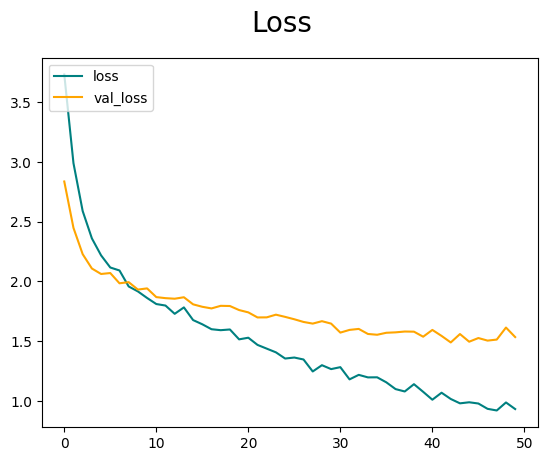

In [34]:
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

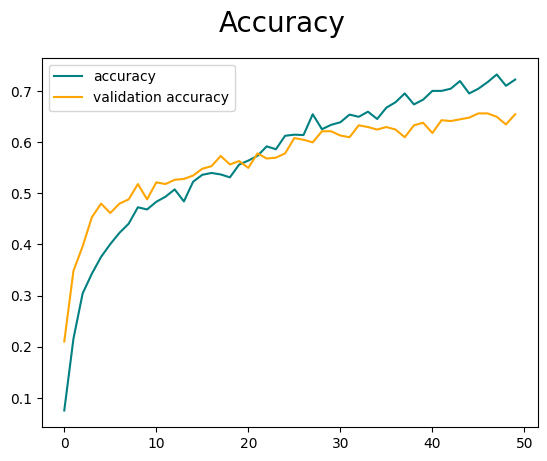

In [35]:
# Accuracy
fig = plt.figure()
plt.plot(hist.history['categorical_accuracy' ], color='teal', label='accuracy')
plt.plot(hist.history["val_categorical_accuracy" ], color='orange', label='validation accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

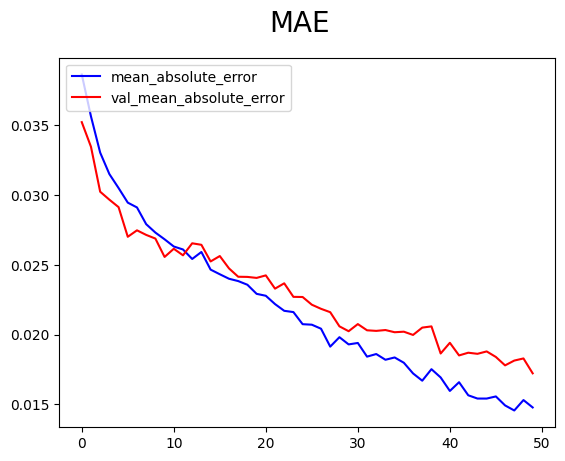

In [36]:
# Error
fig = plt.figure()
plt.plot(hist.history['mean_absolute_error'], color='blue', label='mean_absolute_error')

plt.plot(hist.history['val_mean_absolute_error'], color='red', label='val_mean_absolute_error')

fig.suptitle('MAE', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [37]:
metric_names = list(hist.history.keys())

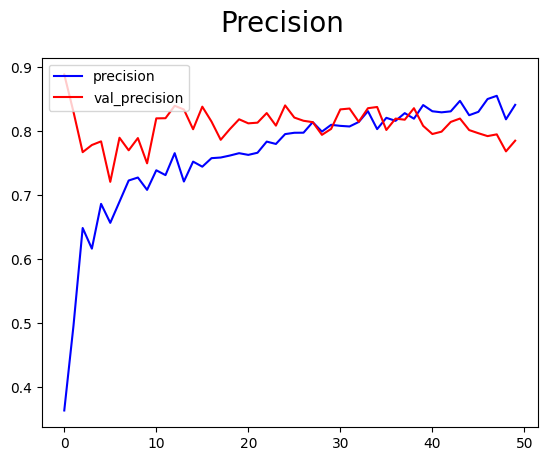

In [38]:
# Precision
fig = plt.figure()
p = [n for n in metric_names if n[:9]=='precision'][0]
vp = [n for n in metric_names if n[:9]=='val_preci'][0]
plt.plot(hist.history[p], color='blue', label='precision')
plt.plot(hist.history[vp], color='red', label='val_precision')

fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

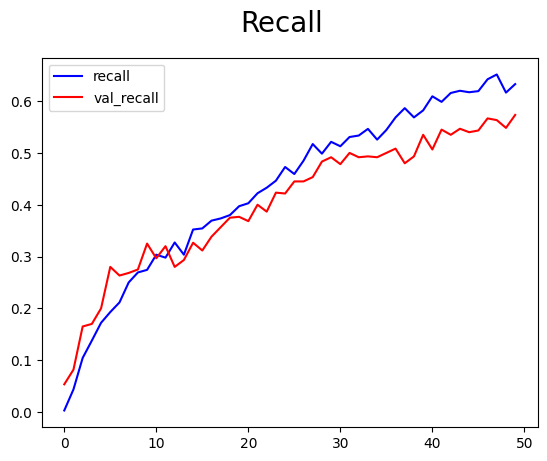

In [39]:
# Recall
fig = plt.figure()
r = [n for n in metric_names if n[:6]=='recall'][0]
vr = [n for n in metric_names if n[:6]=='val_re'][0]
plt.plot(hist.history[r], color='blue', label='recall')
plt.plot(hist.history[vr], color='red', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [40]:
#model = tf.keras.models.load_model(fp)


In [41]:
names_dict
translate = {np.argmax(v):k for k,v in names_dict.items()}
translate

{0: 'Video 35',
 1: 'Video 2',
 2: 'Video 22',
 3: 'Video 36',
 4: 'Video 6',
 5: 'Video 40',
 6: 'Video 46',
 7: 'Video 15',
 8: 'Video 21',
 9: 'Video 24',
 10: 'Video 47',
 11: 'Video 18',
 12: 'Video 41',
 13: 'Video 13',
 14: 'Video 14',
 15: 'Video 9',
 16: 'Video 49',
 17: 'Video 5',
 18: 'Video 16',
 19: 'Video 39',
 20: 'Video 34',
 21: 'Video 30',
 22: 'Video 11',
 23: 'Video 19',
 24: 'Video 28',
 25: 'Video 50',
 26: 'Video 12',
 27: 'Video 27',
 28: 'Video 25',
 29: 'Video 43',
 30: 'Video 7',
 31: 'Video 20',
 32: 'Video 1',
 33: 'Video 3',
 34: 'Video 37',
 35: 'Video 17',
 36: 'Video 29',
 37: 'Video 44',
 38: 'Video 38',
 39: 'Video 4',
 40: 'Video 31',
 41: 'Video 45',
 42: 'Video 33',
 43: 'Video 10',
 44: 'Video 42',
 45: 'Video 8',
 46: 'Video 26',
 47: 'Video 23',
 48: 'Video 32',
 49: 'Video 48'}

In [42]:
# evaluation
from sklearn.metrics import classification_report
pre = Precision()
re = Recall()
acc = CategoricalAccuracy() # I may need another type of accuracy here, 
f1 = F1Score()
fn = tf.keras.metrics.FalseNegatives()
ys = []
yhats = []
for batch in test.as_numpy_iterator( ): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    f1.update_state(y, yhat)
    fn.update_state(y, yhat)
    ys.append(translate[np.argmax(y)])
    yhats.append(translate[np.argmax(yhat)])
    

print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {f1.result().numpy()}, False Positives: {fn.result().numpy()}")

1/1 [==============================] - 0s 14ms/step
Precision: 0.8028985261917114, Recall: 0.5540000200271606, Accuracy: 0.6439999938011169, F1 Score: 0.5728243589401245, False Positives: 223.0


In [43]:
print(classification_report(ys,yhats))

              precision    recall  f1-score   support

     Video 1       1.00      0.70      0.82        10
    Video 10       0.90      0.90      0.90        10
    Video 11       1.00      0.70      0.82        10
    Video 12       0.67      0.60      0.63        10
    Video 13       0.50      0.60      0.55        10
    Video 14       0.53      0.90      0.67        10
    Video 15       1.00      1.00      1.00        10
    Video 16       0.33      0.20      0.25        10
    Video 17       0.45      0.50      0.48        10
    Video 18       0.56      0.90      0.69        10
    Video 19       1.00      0.60      0.75        10
     Video 2       0.11      0.30      0.16        10
    Video 20       0.75      0.60      0.67        10
    Video 21       0.73      0.80      0.76        10
    Video 22       0.42      0.50      0.45        10
    Video 23       0.11      0.10      0.11        10
    Video 24       0.89      0.80      0.84        10
    Video 25       0.67    

In [45]:
models_folder  = DATA_FOLDER+"Models/CNN/"
fn = "cnn-bpts-sparse-acc-67-F1-64-cw.model"
#os.makedirs(models_folder)
#model.save(models_folder+fn)

2023-07-26 02:30:39.588374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,60,300]
	 [[{{node inputs}}]]
2023-07-26 02:30:39.879595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,60,300]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/deborahdarragh/Documents/MCM1_Practicum_Data/Models/CNN/cnn-bpts-sparse-acc-67-F1-64-cw.model/assets


INFO:tensorflow:Assets written to: /home/deborahdarragh/Documents/MCM1_Practicum_Data/Models/CNN/cnn-bpts-sparse-acc-67-F1-64-cw.model/assets
